## Scopus searches of machine learning algorithms in chemistry literature

In this notebook, we search for occurrences of maching learning (ML) algorithm names in literature and visualize the findings. Literature topics are categorized based on the [ACS technical divisions.](https://www.acs.org/content/acs/en/membership-and-networks/join/websites.html) We consider a piece of literature to belong to a division if the title, abstract, or keywords list mention any keyword from the lists written in `acs_divisions.py` These lists contain words found in the titles of symposia for each technical division listed in the "calls for abstracts" for fall and spring ACS national meetings from 2017-2020.

We search for literature with the Scopus API via URL requests. To do the Scopus searches in this notebook (which is optional), you need an API key. [You can get one here.](https://dev.elsevier.com/) Once you get a key, add it to the file `config.json`

In [12]:
import requests
import json
import urllib
import pandas as pd
import numpy as np

from acs_divisions import divisions
from utils import make_df, make_request, get_all_results

# Load configuration, this should contain your API Key
con_file = open("config.json")
config = json.load(con_file)
con_file.close()

Below are the names of machine learning algorithms that we will search. Some names appear in papers that don't explicitly mention ML, thus we have lists that may contain the algorithm name and the words "machine learning."

In [13]:
ml_terms = [['naive bayes'],['bayesian network*'],['genetic algorithm*'],['particle swarm'],['decision tree*'],
           ['random forest*'],['neural network*'],['back propagation','machine learning'],['nearest neigh*','machine learning'],['support vector*'],
           ['regression','machine learning'],['gaussian process','kriging'],['clustering','machine learning']]

In [14]:
years = [[1999,2011],[2010,2021]]

Below is a function to make query strings. This takes a list of keywords, and checks if any or all are found based on the boolean operator provided. A search code is also supplied. The default value is "TITLE-ABS-KEY."

In [15]:
def make_query_string(keywords,boolop="OR",search_code="TITLE-ABS-KEY"):
    """
    Creates a Scopus query string used to search for ANY/ALL
    keyword(s) from a list of keywords in a document's title, abstract, or 
    keyword list using the search code: "TITLE-ABS-KEY"
    """
    qstring = ''
    for i in range(len(keywords)):
        
        if i != len(keywords) - 1:
            qstring += f'\"{keywords[i]}\"' + f' {boolop} '
        
        else:
            qstring += f'\"{keywords[i]}\"'

    qstring = search_code + "(" + qstring + ")"
    
    return qstring

Here we're looping through each division and find occurences of each machine learning algorithm. As mentioned above, some algorithm names need to be searched with the term "machine learning" because those names may occur in documents that aren't related to machine learning, ie. "regression." 

**This step is optional because this cells takes a good amount of time to run. Skip to the cells below the text cell that begins with "! ! ! !" to get the search results.**

In [5]:
divisions = {'AGFD': divisions['AGFD']}
#divisions = {'AGFD': divisions['AGFD'],'GEOC': divisions['GEOC']}
#ml_terms = [['neural network*']]
ml_terms = [['neural network*'],['back propagation','machine learning']]
years = [[1999,2011],[2010,2021]]

In [16]:
df = pd.DataFrame()
results = {}

for year_range in years:
    
    df_dict = {'Year Range' : f'{year_range[0]+1}-{year_range[1]-1}'}
    
    year_dict = {}
    
    for acronym in divisions:
        
        df_dict.update({'Division' : acronym})
    
        division_dict = {}

        for term in ml_terms:

            keywords = divisions[acronym]['keywords']
    
            plain_query = make_query_string(keywords)
        
            if acronym == 'GEOC':
            
                plain_query += " OR " + make_query_string(['mining','geo*'],"AND")
        
            if term[-1] == 'machine learning':
            
                plain_query += " AND " + make_query_string(term,"AND")
            
            else:
            
                plain_query += " AND " + make_query_string(term)
        
            plain_query += f" AND (PUBYEAR > {year_range[0]} AND PUBYEAR < {year_range[1]})"
            request = make_request(plain_query, config['apikey'])
            num_results = request['search-results']['opensearch:totalResults']
            print(year_range, acronym, term[0], num_results)
        
            df_dict.update({term[0] : num_results})
            #df.loc[acronym,term[0]] = num_results
            #df.loc[acronym,'Year Range'] = f'{year_range[0]+1}-{year_range[1]-1}'
        
            division_dict.update({term[0]:request})
        
            #print(plain_query)
            #print()
            
        df = df.append(df_dict,ignore_index=True)
        
        year_dict.update({acronym:division_dict})
        
    results.update({f'{year_range[0]+1}-{year_range[1]-1}':year_dict})


[1999, 2011] AGFD naive bayes 168
[1999, 2011] AGFD bayesian network* 704
[1999, 2011] AGFD genetic algorithm* 3806
[1999, 2011] AGFD particle swarm 349
[1999, 2011] AGFD decision tree* 1640
[1999, 2011] AGFD random forest* 291
[1999, 2011] AGFD neural network* 7576
[1999, 2011] AGFD back propagation 14
[1999, 2011] AGFD nearest neigh* 86
[1999, 2011] AGFD support vector* 3044
[1999, 2011] AGFD regression 217
[1999, 2011] AGFD gaussian process 709
[1999, 2011] AGFD clustering 142
[1999, 2011] AGRO naive bayes 10
[1999, 2011] AGRO bayesian network* 281
[1999, 2011] AGRO genetic algorithm* 1159
[1999, 2011] AGRO particle swarm 106
[1999, 2011] AGRO decision tree* 461
[1999, 2011] AGRO random forest* 59
[1999, 2011] AGRO neural network* 2795
[1999, 2011] AGRO back propagation 2
[1999, 2011] AGRO nearest neigh* 11
[1999, 2011] AGRO support vector* 398
[1999, 2011] AGRO regression 38
[1999, 2011] AGRO gaussian process 1499
[1999, 2011] AGRO clustering 12
[1999, 2011] ANYL naive bayes 116
[1

Saving a CSV file with records of the number of results for each search. This will be used for constructing the visualization.

In [17]:
df.to_csv('search_results.csv')

Saving the raw search results to a JSON file.

In [18]:
df

,Division,Year Range,back propagation,bayesian network*,clustering,decision tree*,gaussian process,genetic algorithm*,naive bayes,nearest neigh*,neural network*,particle swarm,random forest*,regression,support vector*
0,AGFD,2000-2010,14,704,142,1640,709,3806,168,86,7576,349,291,217,3044
1,AGRO,2000-2010,2,281,12,461,1499,1159,10,11,2795,106,59,38,398
2,ANYL,2000-2010,12,1715,130,975,921,4802,116,51,16747,754,166,169,3071
3,BIOT,2000-2010,0,181,36,229,49,825,19,14,2145,75,42,43,441
4,BIOL,2000-2010,0,57,12,121,14,463,21,27,588,23,50,42,415
5,BMGT,2000-2010,0,0,0,0,1,8,0,0,9,0,0,0,2
6,CARB,2000-2010,0,3,1,43,0,77,2,2,159,2,10,3,61
7,CATL,2000-2010,0,21,4,20,18,454,5,2,804,29,5,8,105
8,CELL,2000-2010,0,2,0,15,3,53,0,0,131,1,1,2,14
9,CHED,2000-2010,0,1,0,4,0,9,0,1,24,0,1,1,5


In [22]:
with open('search_results.json','w') as out:
    json.dump(results,out)

**! ! ! !** Here you can read the results of the Scopus searches above.

In [61]:
df_search_results = pd.read_csv('search_results.csv')

Here, we're looping through every keyword in `acs_divisions.py` and counting how many times each are found in literature. This helps us identify the top keywords that contribute to our final results. 

**This step is optional because this cells takes a LONG time to run. Skip to the cells below the text cell that begins with "! ! ! !" to get the search results.**

In [6]:
df = pd.DataFrame()
iloc = -1
for year_range in years:
    
    for div in divisions:
        for keyword in divisions[div]['keywords']:
        
            div_dict = {'Division':div,
                        'Keyword':keyword,
                        'Year Range':f'{year_range[0]+1}-{year_range[1]-1}'}

            num_results_total = 0
            for term in ml_terms:
            
                iloc += 1
            
                plain_query = make_query_string([keyword])
            
                if term[-1] == 'machine learning':
                
                    plain_query += " AND " + make_query_string(term,"AND")
                
                else:
                
                    plain_query += " AND " + make_query_string(term)
                
                plain_query += f" AND (PUBYEAR > {year_range[0]} AND PUBYEAR < {year_range[1]})"
                request = make_request(plain_query, config['apikey'])
                num_results = request['search-results']['opensearch:totalResults']
                print(div, f'{year_range[0]+1}-{year_range[1]-1}', keyword, term[0], num_results)
        
                div_dict.update({term[0]:num_results})
                num_results_total += int(num_results)
            
            div_dict.update({'Total':num_results_total})
            df = df.append(div_dict,ignore_index = True)
                
                #print(plain_query)

AGFD 2000-2010 agricultur* neural network* 1051
AGFD 2000-2010 agricultur* back propagation 1
AGFD 2000-2010 food neural network* 1125
AGFD 2000-2010 food back propagation 1
AGFD 2000-2010 microbiological hazard* neural network* 0
AGFD 2000-2010 microbiological hazard* back propagation 0
AGFD 2000-2010 metabolomic* neural network* 37
AGFD 2000-2010 metabolomic* back propagation 0
AGFD 2000-2010 antibiotic* neural network* 114
AGFD 2000-2010 antibiotic* back propagation 0
AGFD 2000-2010 breath monitoring neural network* 0
AGFD 2000-2010 breath monitoring back propagation 0
AGFD 2000-2010 chocolate* neural network* 5
AGFD 2000-2010 chocolate* back propagation 0
AGFD 2000-2010 traditional chinese medicine neural network* 81
AGFD 2000-2010 traditional chinese medicine back propagation 0
AGFD 2000-2010 wine neural network* 169
AGFD 2000-2010 wine back propagation 2
AGFD 2000-2010 nut* neural network* 332
AGFD 2000-2010 nut* back propagation 1
AGFD 2000-2010 allergen* neural network* 17
AGFD

In [7]:
df

,Division,Keyword,Total,Year Range,back propagation,neural network*
0,AGFD,agricultur*,1052.0,2000-2010,1,1051
1,AGFD,food,1126.0,2000-2010,1,1125
2,AGFD,microbiological hazard*,0.0,2000-2010,0,0
3,AGFD,metabolomic*,37.0,2000-2010,0,37
4,AGFD,antibiotic*,114.0,2000-2010,0,114
5,AGFD,breath monitoring,0.0,2000-2010,0,0
6,AGFD,chocolate*,5.0,2000-2010,0,5
7,AGFD,traditional chinese medicine,81.0,2000-2010,0,81
8,AGFD,wine,171.0,2000-2010,2,169
9,AGFD,nut*,333.0,2000-2010,1,332


Doing a separate search for the number of occurences searching for "mining" AND "geo*"

In [10]:
for year_range in years:
    
    mining_dict = {'Division':'GEOC',
                   'Keyword':'mining',
                   'Year Range':f'{year_range[0]+1}-{year_range[1]-1}'}
    
    num_results_total = 0
    for term in ml_terms:
            
                plain_query = make_query_string(['mining','geo*'],"AND")
            
                if term[-1] == 'machine learning':
                
                    plain_query += " AND " + make_query_string(term,"AND")
                
                else:
                
                    plain_query += " AND " + make_query_string(term)
                    
                plain_query += f" AND (PUBYEAR > {year_range[0]} AND PUBYEAR < {year_range[1]})" 
                request = make_request(plain_query, config['apikey'])
                num_results = request['search-results']['opensearch:totalResults']
                mining_dict.update({term[0]:num_results})
                num_results_total += int(num_results)
                print(f'{year_range[0]+1}-{year_range[1]-1}', term[0], num_results)
                
                #print(plain_query)
            
    mining_dict.update({'Total':num_results_total})
    df = df.append(mining_dict,ignore_index = True)

2000-2010 neural network* 323
2000-2010 back propagation 1
2011-2020 neural network* 867
2011-2020 back propagation 9


In [11]:
df

,Division,Keyword,Total,Year Range,back propagation,neural network*
0,AGFD,agricultur*,1052.0,2000-2010,1,1051
1,AGFD,food,1126.0,2000-2010,1,1125
2,AGFD,microbiological hazard*,0.0,2000-2010,0,0
3,AGFD,metabolomic*,37.0,2000-2010,0,37
4,AGFD,antibiotic*,114.0,2000-2010,0,114
5,AGFD,breath monitoring,0.0,2000-2010,0,0
6,AGFD,chocolate*,5.0,2000-2010,0,5
7,AGFD,traditional chinese medicine,81.0,2000-2010,0,81
8,AGFD,wine,171.0,2000-2010,2,169
9,AGFD,nut*,333.0,2000-2010,1,332


In [27]:
df.to_csv('occurences_of_individual_keywords.csv')

**! ! ! !** Here you can read the results of the searches from the above cells.

In [63]:
df_keywords = pd.read_csv('occurences_of_individual_keywords.csv').drop(columns='Unnamed: 0')

In [64]:
df_keywords

,Division,Keyword,Total,back propagation,bayesian network*,decision tree*,gaussian process,genetic algorithm*,naive bayes,nearest neigh*,neural network*,particle swarm,random forest*,regression,support vector*
0,AGFD,agricultur*,16595.0,44,538,1854,1748,1567,140,133,5689,514,1454,512,2402
1,AGFD,food,9962.0,12,335,1166,215,1145,124,83,4000,513,626,294,1449
2,AGFD,microbiological hazard*,8.0,0,2,6,0,0,0,0,0,0,0,0,0
3,AGFD,metabolomic*,1102.0,2,41,112,5,94,10,11,156,7,334,78,252
4,AGFD,antibiotic*,1624.0,1,71,583,10,196,13,14,354,14,117,55,196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,SCHB,chem* sector*,4.0,0,0,0,0,0,0,0,3,0,0,0,1
540,SCHB,academic entrepreneur*,2.0,0,2,0,0,0,0,0,0,0,0,0,0
541,SCHB,commercial chem*,7.0,0,0,2,0,0,1,0,1,0,1,0,2
542,SCHB,science advoca*,1.0,0,0,1,0,0,0,0,0,0,0,0,0


Here we find the top five frequently found keywords for each division.

In [65]:
df_top_five = pd.DataFrame()

for div in divisions:
    
    five = df_keywords.loc[df_keywords['Division'] == div]['Total'].nlargest(5).index
    five_df = df_keywords.iloc[five][['Division','Keyword','Total']]
    df_top_five = pd.concat([df_top_five,five_df])

In [66]:
df_top_five

,Division,Keyword,Total
45,AGFD,protein*,28984.0
0,AGFD,agricultur*,16595.0
1,AGFD,food,9962.0
36,AGFD,fruit*,5217.0
9,AGFD,nut*,4852.0
...,...,...,...
538,RUBB,rubber*,1068.0
541,SCHB,commercial chem*,7.0
539,SCHB,chem* sector*,4.0
540,SCHB,academic entrepreneur*,2.0


Write new CSV with top fives

In [32]:
df_top_five.to_csv('top_five_keywords.csv')

List of ML algorithm names to label the heatmap properly.

In [67]:
ml_terms_formatted = ['Back Propagation + ML','Nearest Neighbors + ML','Naive Bayes','Regression + ML',
                      'Bayesian Networks','Random Forest','Particle Swarm','Gaussian Process/Kriging',
                      'Decision Tree','Support Vectors','Genetic Algorithms','Neural Networks']

Now we'll read in the data from the Scopus searches and organize the data for our visualization.

In [68]:
df = pd.read_csv('search_results.csv')

Rearranging rows so that they are in order of decreasing average number of occurences.

In [69]:
df = df.reindex(df.mean(axis=1).sort_values().index[::-1], axis=0)

In [70]:
divisions = df['Unnamed: 0'].values
df = df.drop(labels=['Unnamed: 0'], axis=1)

Rearranging columns so that they are in order of increasing average number of occurrences.

In [71]:
df = df.reindex(df.mean().sort_values().index, axis=1)

Extracting the numerical values to a separate array and taking the natural log of the values.

In [72]:
data = df.values
data = data + 1
data = np.log(data)

Reading in top key words from individual searches.

In [73]:
top_key = pd.read_csv('top_five_keywords.csv')
top_key

,Unnamed: 0,Division,Keyword,Total
0,45,AGFD,protein*,28984.0
1,0,AGFD,agricultur*,16595.0
2,1,AGFD,food,9962.0
3,36,AGFD,fruit*,5217.0
4,9,AGFD,nut*,4852.0
...,...,...,...,...
135,538,RUBB,rubber*,1068.0
136,541,SCHB,commercial chem*,7.0
137,539,SCHB,chem* sector*,4.0
138,540,SCHB,academic entrepreneur*,2.0


Here we'll construct a dataframe that contains the top five keywords in a more organized manner.

In [74]:
df1 = pd.DataFrame()
for div in divisions:
    
    div_df = top_key.loc[top_key['Division'] == div]['Keyword']
    
    df_dict = {'Division':div}
    
    for i,row in enumerate(div_df):
        
        df_dict.update({str(i+1):[row]})
     
    temp_df = pd.DataFrame(df_dict)
    df1 = pd.concat([df1,temp_df])

In [75]:
df1 = df1.fillna('None')

Saving to CSV

In [43]:
df1.to_csv('top_five_keywords_reformatted.csv')

Constructing a new dataframe that contains percentages with the top keywords

In [76]:
df3 = pd.read_csv('occurences_of_individual_keywords.csv')

In [77]:
df1['Total All Keywords'] = df1['Division'].apply(lambda x: df3.loc[df3['Division'] == x]['Total'].sum())
df1.head()

,Division,1,2,3,4,5,Total All Keywords
0,PHYS,electro*,spectroscopy,ion*,nano*,quantum*,173307.0
0,ANYL,sensor*,spectroscopy,characterization*,spectrometry,groundwater,126970.0
0,ENVR,*sensor*,soil*,water quality,environmental monitor*,cataly*,118211.0
0,AGFD,protein*,agricultur*,food,fruit*,nut*,91406.0
0,ENFL,fuel*,petroleum,energy efficiency,batter*,renewable energy,73669.0


In [78]:
df4 = pd.DataFrame()
for div in divisions:
    df_dict = {'Division':div}
    for num in ['1','2','3','4','5']:
        div_dict = df1.loc[df1['Division'] == div]
        kw = div_dict[num].values[0]
        
        if kw != 'None': 
            kw_tot = df3.loc[(df3['Division'] == div) & (df3['Keyword'] == kw)]['Total'].values[0]
            div_tot = div_dict['Total All Keywords'].values[0]
            percentage = np.round(100 * ( kw_tot / div_tot), 1)
            df_dict.update({num:kw+f' ({percentage}%)'})
            
        else:
            df_dict.update({num:'None'})
            
    df4 = df4.append(df_dict, ignore_index=True)

In [79]:
df4 = df4[['Division','1','2','3','4','5']]
df4.head()

,Division,1,2,3,4,5
0,PHYS,electro* (56.2%),spectroscopy (9.7%),ion* (6.0%),nano* (5.5%),quantum* (5.4%)
1,ANYL,sensor* (55.3%),spectroscopy (13.2%),characterization* (11.6%),spectrometry (4.3%),groundwater (3.6%)
2,ENVR,*sensor* (60.7%),soil* (14.5%),water quality (4.2%),environmental monitor* (3.1%),cataly* (3.0%)
3,AGFD,protein* (31.7%),agricultur* (18.2%),food (10.9%),fruit* (5.7%),nut* (5.3%)
4,ENFL,fuel* (19.1%),petroleum (11.6%),energy efficiency (11.2%),batter* (10.6%),renewable energy (8.0%)


In [48]:
df4.to_csv('top_five_keywords_with_percentages.csv')

Finally, we can visualize the results in a heatmap below.

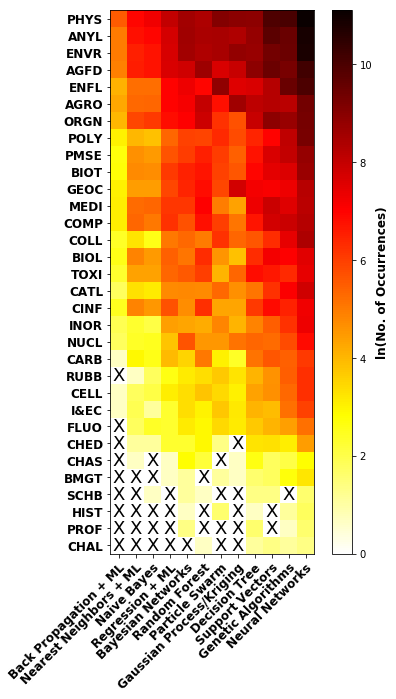

<Figure size 432x288 with 0 Axes>

In [81]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=[20,10])
im = ax.imshow(data, cmap='hot_r')
#im = ax.pcolor(data, cmap='hot_r', edgecolors='k', linewidths=0.5)

ax.set_xticks(np.arange(len(ml_terms_formatted)))
ax.set_yticks(np.arange(len(divisions)))

ax.set_xticklabels(ml_terms_formatted, fontweight = 'bold', fontsize = 12)
ax.set_yticklabels(divisions, fontweight = 'bold', fontsize = 12)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.25)

cb = plt.colorbar(im, cax=cax)
cb.set_label(label='ln(No. of Occurrences)',weight='bold',size=12)

for i in range(len(divisions)):
    for j in range(len(ml_terms_formatted)):
        if data[i, j] == 0:
            text = ax.text(j, i, 'X',ha="center", va="center", color="k", size=18)

#table = plt.table(cellText=text_data,loc='upper center',colWidths=[5]*5,rowLabels=divisions)
            
plt.show()
plt.tight_layout()
#plt.savefig('heatmap.png',format='png',dpi=600)

A square in the heatmap represents the natural log of the number of occurrences of an ML algorithm name in literature that belong to an ACS division. Squares with an "X" mean that there were zero occurrences. We can observe from this figure that the PHYS division and Neural Networks had the most literature hits, and divisions like HIST, PROF, and CHAL don't have many pieces of literature that mention ML algorithms.